# Лабораторная работа 3
## Методы приближения функции. Численные дифференциирование и интегрирование

In [108]:
import numpy as np
from math import tan, pi, log
import matplotlib.pyplot as plt
from bisect import bisect
from prettytable import PrettyTable

In [132]:
def spline_interpolation(x, y, x_test):
    """
    Get cubic spline interpolation s(x) of tabular function y = f(x)
    s(x) = a + b(x - x_{i-1}) + c(x - x_{i-1})^2 + d(x - x_{i-1})^3
    Returns:
        arrays of coefficients a, b, c, d for each interval,
        s(x_test)
    """
    assert len(x) == len(y)
    n = len(x)

    # Step 1. Get c coefs
    h = [x[i] - x[i - 1] for i in range(1, len(x))]
    # tridiagonal matrix for calculating c:
    A = [[0 for _ in range(len(h)-1)] for _ in range(len(h)-1)]
    A[0][0] = 2 * (h[0] + h[1])
    A[0][1] = h[1]
    for i in range(1, len(A) - 1):
        A[i][i-1] = h[i-1]
        A[i][i] = 2 * (h[i-1] + h[i])
        A[i][i+1] = h[i]
    A[-1][-2] = h[-2]
    A[-1][-1] = 2 * (h[-2] + h[-1])

    m = [3.0 * ((y[i+1] - y[i]) / h[i] - (y[i] - y[i-1]) / h[i-1]) for i in range(1, len(h))]

    c = [0] + tridiagonal_solve(A, m)

    # Step 2. Get a coefs
    a = [y[i-1] for i in range(1, n)]

    # Step 3. Get b coefs
    b = [(y[i] - y[i-1]) / h[i-1] - (h[i-1] / 3.0) * (2.0 * c[i-1] + c[i]) for i in range(1, len(h))]
    b.append((y[-1] - y[-2]) / h[-1] - (2.0 * h[-1] * c[-1]) / 3.0)

    # Step 4. Get d coefs
    d = [(c[i] - c[i-1]) / (3.0 * h[i-1]) for i in range(1, len(h))]
    d.append(-c[-1] / (3.0 * h[-1]))

    # Calculate s(x_test)
    for interval in range(len(x)):
        if x[interval] <= x_test < x[interval+1]:
            i = interval
            break
    y_test = s(a[i + 1], b[i + 1], c[i + 1], d[i + 1], x_test - x[i])
    return a, b, c, d, y_test

### 3.1. Используя таблицу значений $Y_i$ функции $y=f(x)$, вычисленных в точках $X_i, i=0,...,3$ построить интерполяционные многочлены Лагранжа и Ньютона, проходящие через точки ${X_i, Y_i}$.  Вычислить значение погрешности интерполяции в точке $X^*$.

In [109]:
f = lambda x: 1/ tan(x)
x1 = [0.125*pi, 0.25*pi, 0.375*pi, 0.5*pi]
x2 = [0.125*pi, 0.3125*pi, 0.375*pi, 0.5*pi]
y1 = [f(x) for x in x1]
y2 = [f(x) for x in x2]
X = pi / 3

#### Интерполяционный многочлен Лагранжа

In [110]:
def Lagrange_polynomial(x, y):
    class FunctorList:
        def __init__(self, func_list):
            self.func_list = func_list
        def __call__(self, X):
            return np.array([func(X) for func in self.func_list])
    x, y = np.array(x), np.array(y)
    n = len(x)
    func_part = FunctorList([lambda X, i=i: (np.array([X]*(n-1)) - np.concatenate((x[:i], x[i+1:]))).prod() for i in range(n)])
    omega_der = [(np.array([x[i]]*(len(x)-1)) - np.concatenate((x[:i], x[i+1:]))).prod() for i in range(n)]
    const_part = y / np.array(omega_der)
    return lambda X: (const_part * func_part(X)).sum()

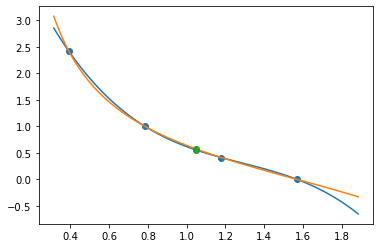

P(1.0471975511965976) = 0.5579748085542389
f(1.0471975511965976) = 0.577350269189626
Абсолютная погрешность интерполяции составляет 0.019375460635387087


In [111]:
P = np.vectorize(Lagrange_polynomial(x1, y1))
f = np.vectorize(f)
x_grid = np.linspace(0.1*pi, 0.6*pi, 100)
plt.plot(x_grid, P(x_grid))
plt.plot(x_grid, f(x_grid))
plt.plot([X, X], [P(X), f(X)], marker='o')
plt.scatter(x1, y1)
plt.show()
print(f'P({X}) = {P(X)}')
print(f'f({X}) = {f(X)}')
print('Абсолютная погрешность интерполяции составляет', abs(P(X) - f(X)))

#### Интерполяционный многочлен Ньютона

In [112]:
def Newton_polynomial(x, y):
    x, y = np.array(x), np.array(y)
    n = len(x)
    f = [y]
    for i in range(1, n):
        f.append(np.array([(f[-1][j] - f[-1][j+1]) / (x[j] - x[i+j]) for j in range(n-i)]))
    def ret(X):
        ans = f[0][0]
        acc = 1
        for i in range(n-1):
            acc *= X - x[i]
            ans += acc * f[i+1][0]
        return ans
    return ret

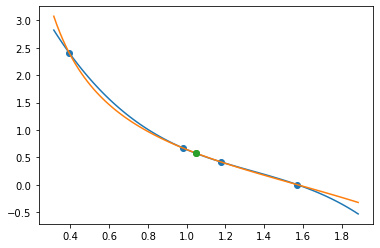

P(1.0471975511965976) = 0.5734953726581077
f(1.0471975511965976) = 0.577350269189626
Абсолютная погрешность интерполяции составляет 0.0038548965315182704


In [113]:
P = np.vectorize(Newton_polynomial(x2, y2))
f = np.vectorize(f)
x_grid = np.linspace(0.1*pi, 0.6*pi, 100)
plt.plot(x_grid, P(x_grid))
plt.plot(x_grid, f(x_grid))
plt.plot([X, X], [P(X), f(X)], marker='o')
plt.scatter(x2, y2)
plt.show()
print(f'P({X}) = {P(X)}')
print(f'f({X}) = {f(X)}')
print('Абсолютная погрешность интерполяции составляет', abs(P(X) - f(X)))

### 3.2. Построить кубический сплайн для функции, заданной в узлах интерполяции, предполагая, что сплайн имеет нулевую кривизну при $x=x_0$ и $x=x_4$. Вычислить значение функции в точке $x=X^*$.

In [114]:
#x = [0, 1, 2, 3, 4]
#y = [0.0, 0.5, 0.86603, 1.0, 0.86603]
#X = 1.5

x = [1.0, 1.9, 2.8, 3.7, 4.6]
y = [2.4142, 1.0818, 0.50953, 0.11836, -0.24008]
X = 2.66666667

In [131]:
def tridiagonal_algo(A, b):
    alfa = [0] + [A[i+1][i] for i in range(len(A)-1)]
    beta = [-A[i][i] for i in range(len(A))]
    gamma = [A[i][i+1] for i in range(len(A)-1)] + [0]
    P = [gamma[0] / beta[0]]
    Q = [-b[0] / beta[0]]
    for i in range(1, len(A)-1):
        P.append(gamma[i] / (beta[i] - alfa[i] * P[i-1]))
        Q.append((alfa[i] * Q[i-1] - b[i]) / (beta[i] - alfa[i] * P[i-1]))
    x = [(alfa[-1] * Q[-1] - b[-1]) / (beta[-1] - alfa[-1] * P[-1])]
    for i in range(len(A)-2, -1, -1):
        x.append(P[i] * x[-1] + Q[i])
    return x[::-1]

In [129]:
def Cubic_spline(x, y):
    n = len(x)
    h = [0] + [x[i]-x[i-1] for i in range(1, n)]
    k = [[h[i-1], 2*(h[i-1]+h[i]), h[i]] for i in range(2, n)]
    v = [3 * ((y[i]-y[i-1])/h[i] - (y[i-1]-y[i-2])/h[i-1]) for i in range(2, n)]
    A = np.array([[0]*len(k)]*len(k))
    for i in range(len(A)-1):
        A[i+1][i] = k[i+1][0]
    for i in range(len(A)):
        A[i][i] = k[i][1]
    for i in range(len(A)-1):
        A[i][i+1] = k[i][2]
    c = [0,0] + tridiagonal_algo(A, v)
    a = [0,0] + y[1:-1]
    b = [0] + [(y[i] - y[i-1]) / h[i] - h[i] * (c[i+1] + 2*c[i]) / 3 for i in range(1, n-1)] + [(y[n-1] - y[n-2]) / h[n-1] - 2/3 * h[n-1]*c[n-1]]
    d = [0] + [(c[i+1] - c[i]) / (3 * h[i]) for i in range(1, n-1)] + [-c[n-1]/(3*h[n-1])]
    xx = [0] + [(x[i], x[i+1]) for i in range(n-1)]
    spline_table = list(zip(xx[1:], a[1:], b[1:], c[1:], d[1:]))
    def f(a, t):
        b = 0
        for ai in a: b = ai + b*t
        return b
    def func(X):
        for line in spline_table:
            if line[0][0] <= X <= line[0][1]:
                return f(line[1:][::-1], X - line[0][0])
    return func

[1.0; 1.9)
s(x) = 2.4142 + -1.6929500000000002(x - 1.0) + 0(x - 1.0)^2 + 0.2623525377229081(x - 1.0)^3


[1.9; 2.8)
s(x) = 1.0818 + -1.0554333333333337(x - 1.9) + 0.7083518518518519(x - 1.9)^2 + -0.26906035665294914(x - 1.9)^3


[2.8; 3.7)
s(x) = 0.50953 + -0.43421666666666664(x - 2.8) + -0.01811111111111075(x - 2.8)^2 + 0.01960905349794211(x - 2.8)^3


[3.7; 4.6)
s(x) = 0.11836 + -0.41916666666666663(x - 3.7) + 0.034833333333332966(x - 3.7)^2 + -0.012901234567901106(x - 3.7)^3


s(x_test) = s(2.66666667) = 0.17482166600404656


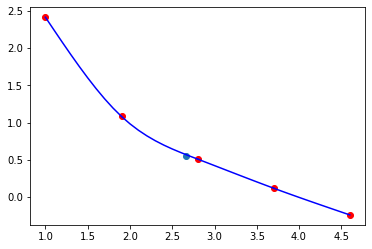

In [136]:
P = np.vectorize(Cubic_spline(x, y))
#x_grid = np.linspace(1.91, 5, 100)
#x_grid1 = np.linspace(x[0], x[1], 100)
#plt.plot(x_grid, P(x_grid), color='b')
#plt.plot(x_grid1, P(x_grid1) + 2.4, color='b')
#plt.scatter(x, y)
#plt.scatter(X, P(X))
#plt.show()
#print(f'P({X}) = {P(X)}')

def draw_plot(x_original, y_original, a, b, c, d):
    x, y = [], []
    for i in range(len(x_original) - 1):
        x1 = np.linspace(x_original[i], x_original[i + 1], 10)
        y1 = [s(a[i], b[i], c[i], d[i], j - x_original[i]) for j in x1]
        x.append(x1)
        y.append(y1)

    plt.scatter(x_original, y_original, color='r')
    for i in range(len(x_original) - 1):
        plt.plot(x[i], y[i], color='b')
    plt.scatter(X, P(X))
    plt.show()
    
a, b, c, d, y_test = spline_interpolation(x, y, x_test)
for i in range(len(x) - 1):
    print(f'[{x[i]}; {x[i+1]})')
    print(f's(x) = {a[i]} + {b[i]}(x - {x[i]}) + {c[i]}(x - {x[i]})^2 + {d[i]}(x - {x[i]})^3')
    print('\n')
    
print(f's(x_test) = s({x_test}) = {y_test}')
draw_plot(x, y, a, b, c, d)

### 3.3. Для таблично заданной функции путем решения нормальной системы МНК найти приближающие многочлены a) 1-ой и б) 2-ой степени. Для каждого из приближающих многочленов вычислить сумму квадратов ошибок. Построить графики приближаемой функции и приближающих многочленов.

In [54]:
x = [1.0, 1.9, 2.8, 3.7, 4.6, 5.5]
y = [2.4142, 1.0818, 0.50953, 0.11836, -0.24008, -0.66818]

In [55]:
class LU:
    EPS = 1e-6

    def __init__(self, U):
        L = np.eye(len(U), dtype=float)
        isDetNeg = False
        permut = np.array(range(len(U)))
        for i in range(len(U)):
            max_idx = i
            for j in range(i + 1, len(U)):
                if abs(U[max_idx][i]) < abs(U[j][i]):
                    max_idx = j
            if max_idx != i:
                U[[i, max_idx]] = U[[max_idx, i]]
                L[[i, max_idx]] = L[[max_idx, i]]
                L[:, [i, max_idx]] = L[:, [max_idx, i]]
                isDetNeg = not isDetNeg
                permut[[i, max_idx]] = permut[[max_idx, i]]
            if abs(U[i][i]) < self.EPS: continue
            for j in range(i + 1, len(U)):
                mu = U[j][i] / U[i][i]
                L[j][i] = mu
                for k in range(len(U)):
                    U[j][k] -= mu * U[i][k]
        det = U.diagonal().prod()
        if isDetNeg: det = -det
        self._permut = permut
        self.L = L
        self.U = U
        self.det = det

    def solve(self, b):
        b = np.array([ b[pi] for pi in self._permut ], dtype=float)
        z = np.array([0] * len(b), dtype=float)
        for i in range(len(b)):
            z[i] = b[i]
            for j in range(i):
                z[i] -= self.L[i, j] * z[j]
        x = np.array([0] * len(b), dtype=float)
        for i in range(len(b)-1, -1, -1):
            if abs(self.U[i, i]) < self.EPS: continue
            x[i] = z[i]
            for j in range(len(b)-1, i, -1):
                x[i] -= x[j] * self.U[i, j]
            x[i] /= self.U[i, i]
        return x

In [56]:
    def inverse(self):
        n = len(self.L)
        ret = np.matrix([[0] * n] * n, dtype=float)
        for i in range(n):
            b = np.array([0] * n, dtype=float)
            b[i] = 1
            ret[:, i] = np.matrix(self.solve(b)).T
        return ret

In [57]:
def least_square_method(x, y, deg=1):
    x, y = np.array(x), np.array(y)
    xk = np.array([1.0]*len(x))
    A = np.array([[0.0]*(deg+1)]*(deg+1))
    b = [y.sum()]
    A[0][0] = len(x)
    for i in range(1, 2*deg+1):
        xk *= x
        sx = xk.sum()
        if i <= deg:
            b.append((y * xk).sum())
            for j in range(i+1):
                A[-j-(deg-i)-1][j] = sx
        else:
            for j in range(2*deg-i+1):
                A[-j-1][j+i-deg] = sx
    a = LU(A).solve(b)
    def f(a, t):
        b = 0
        for ai in a:
            b = ai + b*t
        return b
    return lambda X: f(a[::-1], X)

In [58]:
def square_error(y, p):
    return sum([(y[i]-p[i])**2 for i in range(len(y))])

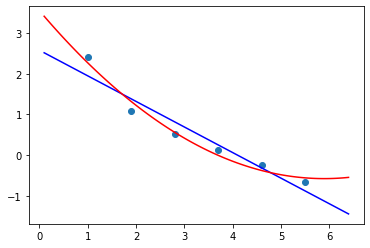

Сумма квадратов ошибок многочлена степени 1: 0.4701221112819048
Сумма квадратов ошибок многочлена степени 2: 0.1259531432771428


In [59]:
P1 = np.vectorize(least_square_method(x, y, 1))
P2 = np.vectorize(least_square_method(x, y, 2))
x_grid = np.linspace(2*x[0]-x[1], 2*x[-1]-x[-2], 100)
plt.plot(x_grid, P1(x_grid), color = 'b')
plt.plot(x_grid, P2(x_grid), color = 'r')
plt.scatter(x, y)
plt.show()
print('Сумма квадратов ошибок многочлена степени 1:', square_error(y, P1(x)))
print('Сумма квадратов ошибок многочлена степени 2:', square_error(y, P2(x)))

### 3.4. Вычислить первую и вторую производную от таблично заданной функции $y_i=f(x_i), i=0,1,2,3,4$ в точке $x=X^*$.

In [17]:
#Var_1
#x = [-1, 0, 1, 2, 3]
#y = [-0.5, 0.0, 0.50, 0.86603, 1.0]
#X = 1

#Var_3
#x = [1.0, 1.5, 2.0, 2.5, 3.0]
#y = [0.0, 0.40547, 0.69315, 0.91629, 1.0986]
#X = 2.0

#Var_4 
x = [0.0, 0.1, 0.2, 0.3, 0.4]
y = [1.0, 1.1052, 1.2214, 1.3499, 1.4918]
X = 0.2

In [18]:
def derivative(x, y):
    def f(X):
        li, ri = max(0, bisect(x, X)-1), min(len(x)-1, bisect(x, X))
        i = li if X - x[li] < x[ri] - X else ri
        if i == 0: i += 1
        elif i == len(x)-1: i -=1
        return (y[i]-y[i-1])/(x[i]-x[i-1]) + ((y[i+1]-y[i])/(x[i+1]-x[i]) - (y[i]-y[i-1])/(x[i]-x[i-1]))/(x[i+1]-x[i-1]) * (2*X-x[i-1]-x[i])
    return f

In [19]:
def derivative_2(x, y):
    def f(X):
        li, ri = max(0, bisect(x, X)-1), min(len(x)-1, bisect(x, X))
        i = li if X - x[li] < x[ri] - X else ri
        if i == 0: i += 1
        elif i == len(x)-1: i -=1
        return 2 * ((y[i+1]-y[i])/(x[i+1]-x[i])-(y[i]-y[i-1])/(x[i]-x[i-1]))/(x[i+1]-x[i-1])
    return f

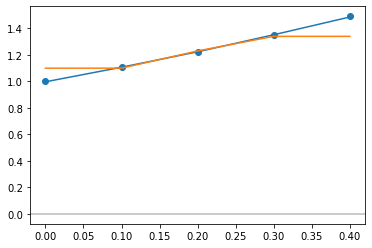

f'(0.2) = 1.223500000000001
f''(0.2) = 1.23


In [20]:
df = np.vectorize(derivative(x, y))
d2f = np.vectorize(derivative_2(x, y))
x_grid = np.linspace(x[0], x[-1], 100)
plt.axhline(0, color='black', linewidth=0.4)
plt.plot(x, df(x))
plt.plot(x, d2f(x))
# plt.plot(x_grid, df(x_grid))
# plt.plot(x_grid, d2f(x_grid))
plt.scatter(x, y)
plt.show()
print(f'f\'({X}) = {df(X)}')
print(f'f\'\'({X}) = {d2f(X)}')

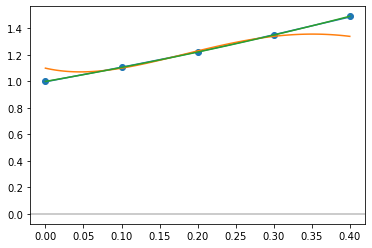

In [21]:
f_inter = np.vectorize(Newton_polynomial(x, y))
df = np.vectorize(derivative(x, y))
df_inter = np.vectorize(Newton_polynomial(x, df(x)))
d2f = np.vectorize(derivative_2(x, y))
d2f_inter = np.vectorize(Newton_polynomial(x, d2f(x)))
x_grid = np.linspace(x[0], x[-1], 100)
plt.axhline(0, color='black', linewidth=0.4)
plt.plot(x_grid, df_inter(x_grid))
plt.plot(x_grid, d2f_inter(x_grid))
plt.plot(x_grid, f_inter(x_grid))
plt.scatter(x, y)
plt.show()

### 3.5. Вычислить определенный интеграл $F=\int_{x_0}^{x_1}y\ dx$ методами прямоугольников, трапеций, Симпсона с шагами $h_1, h_2$. Оценить погрешность вычислений, используя Метод Рунге-Ромберга.

In [137]:
f = np.vectorize(lambda x: (3*x + 4) / (2*x + 7))
x0, xk = -2, 2
h1, h2 = 1.0, 0.5
x1 = np.linspace(x0, xk, int((xk - x0) / h1)+1)
x2 = np.linspace(x0, xk, int((xk - x0) / h2)+1)
ans = 1.77733 # значение интеграла по калькулятору

In [138]:
def rectangle_method(x, f):
    x = np.array(x)
    h = x[1] - x[0]
    f = np.vectorize(f)
    return h * sum(f((x[:-1] + x[1:]) / 2))

In [139]:
def trapezoidal_method(x, f):
    h = x[1] - x[0]
    f = np.vectorize(f)
    return h * ((f(x[0])+f(x[-1]))/2 + sum(f(x[1:-1])))

In [140]:
def Simpson_method(x, f):
    x = np.array(x)
    h = x[1] - x[0]
    f = np.vectorize(f)
    return h / 3 * (f(x[0]) - f(x[-1]) + 4*sum(f(x[1::2])) + 2*sum(f(x[2::2])))

In [141]:
def Runge_Romberg_Richardson_method(F_h, F_kh, k, p):
    return F_h + (F_h - F_kh) / (k**p - 1)

+-----------------+--------------------+--------------------+-------------------------+------------------------+
|      Метод      |    Шаг h1 = 1.0    |    Шаг h2 = 0.5    | Рунге-Ромберг-Ричардсон |    Абс.погрешность     |
+-----------------+--------------------+--------------------+-------------------------+------------------------+
| Прямоугольников | 1.8291666666666666 | 1.7909819111057501 |    1.7527971555448336   |  0.024532844455166458  |
|     Трапеций    | 1.6704184704184701 | 1.7497925685425686 |    1.7762506012506014   | 0.0010793987493986634  |
|     Симпсона    | 1.7654641654641652 | 1.776250601250601  |    1.7777915206486632   | 0.00046152064866311626 |
+-----------------+--------------------+--------------------+-------------------------+------------------------+


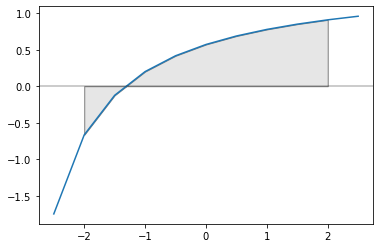

In [144]:
int1_rec = rectangle_method(x1, lambda x: (3*x + 4) / (2*x + 7))
int1_trp = trapezoidal_method(x1, lambda x: (3*x + 4) / (2*x + 7))
int1_sim = Simpson_method(x1, lambda x: (3*x + 4) / (2*x + 7))
int2_rec = rectangle_method(x2, lambda x: (3*x + 4) / (2*x + 7))
int2_trp = trapezoidal_method(x2, lambda x: (3*x + 4) / (2*x + 7))
int2_sim = Simpson_method(x2, lambda x: (3*x + 4) / (2*x + 7))
rrr1_rec = Runge_Romberg_Richardson_method(int1_rec, int2_rec, h2 / h1, 1)
rrr1_trp = Runge_Romberg_Richardson_method(int1_trp, int2_trp, h2 / h1, 2)
rrr1_sim = Runge_Romberg_Richardson_method(int1_sim, int2_sim, h2 / h1, 3)

table = PrettyTable()
table.field_names = ['Метод', f'Шаг h1 = {h1}', f'Шаг h2 = {h2}', 'Рунге-Ромберг-Ричардсон', 'Абс.погрешность']
table.add_row(['Прямоугольников', int1_rec, int2_rec, rrr1_rec, abs(ans - rrr1_rec)])
table.add_row(['Трапеций', int1_trp, int2_trp, rrr1_trp, abs(ans - rrr1_trp)])
table.add_row(['Симпсона', int1_sim, int2_sim, rrr1_sim, abs(ans - rrr1_sim)])
print(table)

x2grid = [x2[0]-h2] + list(x2) + [x2[-1]+h2]
plt.plot(x2grid, f(x2grid))
plt.axhline(0, color='black', linewidth=0.4)
plt.fill_between(x2grid, f(x2grid), where=[x2[0]<=xi<=x2[-1] for xi in x2grid], facecolor='0.9', edgecolor='0.5')
plt.show()